# Ensemble Time Series

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore")

# List of Stocks and ETFs
Provided by Thomas Choi.

In [2]:
stock_list = pd.read_csv("../stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("../stocks_and_etfs/etf_list.csv")

In [3]:
import random
# Choose a random stock
#stock_symbol = random.choice(stock_list.iloc[:,0])
stock_symbol = "FCX"
print(stock_symbol)

FCX


## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [4]:
import os
import sys
import mysql.connector

HOST="143.244.188.157"
PORT="3306"
USER="patrick-finProj"
PASSWORD="Pat#21$rick"

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

# Data

In [5]:
df = histdailyprice3.copy()
df.head()

,Date,Close,Open,High,Low,Volume
0,1998-01-01,7.875,7.875,7.875,7.875,0
1,1998-01-02,7.875,8.000,7.875,7.970,279300
2,1998-01-05,7.970,8.000,7.845,7.875,455300
3,1998-01-06,7.845,7.875,7.750,7.750,476200
4,1998-01-07,7.720,7.875,7.685,7.845,464100


# Normalize

In [6]:
from sklearn.preprocessing import MinMaxScaler
# normalize data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Train-Test Split

In [7]:
def create_dataset(dataset, time_step=1):
    x_data, y_data = [], []
    
    for i in range(len(dataset)-time_step-1):
        x_data.append(dataset[i:(i+time_step), 0])
        y_data.append(dataset[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

In [8]:
# Preparing train and test data
training_size = int(len(scaled_data)*0.65)
test_size = len(scaled_data)-training_size
train_data, test_data = scaled_data[0:training_size,:], scaled_data[training_size:len(scaled_data),:1]

In [9]:
#Taking data for past 100 days for next prediction
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# Build LSTM Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM

def build_model(hp):
    model = Sequential()
    model.add(layers.LSTM(units = hp.Choice('layer1_units', [10,20,30,40,50,60,70,80,90,100]),return_sequences=True,input_shape=(100,1)))
    
    for i in range(hp.Int('num_layers', 2, 15)):                        
        model.add(layers.LSTM(units =  hp.Int('units' + str(i), min_value=10, max_value=150, step=10), return_sequences=True))
    
    model.add(LSTM(units = hp.Choice('last_lstm_units', [50, 100, 150])))
    model.add(Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5, 0.6, 0.7])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam' )
    return model

## Tuning

In [12]:
import keras_tuner
from tensorflow.keras import layers
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials= 5,
    executions_per_trial=3,
    directory='tuner', project_name = f'{stock_symbol}', njobs=8)

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs= 5,
             validation_data=(X_test, ytest))

Trial 6 Complete [00h 23m 19s]
val_loss: 0.001871472845474879

Best val_loss So Far: 0.0014150745701044798
Total elapsed time: 01h 40m 37s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

Results summary
Results in project/Stacked_LSTM_Stock_Prediction
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layer1_units: 60
num_layers: 9
units0: 140
units1: 110
last_lstm_units: 50
rate: 0.7
units2: 120
units3: 30
units4: 120
units5: 150
units6: 10
units7: 10
units8: 10
units9: 110
units10: 80
Score: 0.0014150745701044798
Trial summary
Hyperparameters:
layer1_units: 80
num_layers: 9
units0: 30
units1: 100
last_lstm_units: 50
rate: 0.6
units2: 20
units3: 150
units4: 30
units5: 100
units6: 140
units7: 90
units8: 120
units9: 100
units10: 110
units11: 10
units12: 100
Score: 0.001871472845474879
Trial summary
Hyperparameters:
layer1_units: 20
num_layers: 13
units0: 100
units1: 30
last_lstm_units: 100
rate: 0.3
units2: 10
units3: 50
units4: 80
units5: 130
units6: 80
units7: 100
units8: 140
units9: 70
units10: 150
units11: 30
units12: 50
Score: 0.00211524055339396
Trial summary
Hyperparameters:
layer1_units: 90
num_layers: 13
units0: 11

# Callbacks
**EarlyStoping:** It will stop the traning if score of model didn't increase. This prevent model from overfitting. We are to set max in 10 epoches if it didn't increase then we will stop the training <br>
**ReduceLROnPlateau:** Use for reduce the learning rate. In 3 steps the score didn't increase we will reduce the learning rate to improve the training <br>
**ModelCheckpoint:** Use for save model only when the score increased

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('weights_best.hdf5', verbose=2, save_best_only=True, 
                    save_weights_only=True)
]

# Compile LSTM Model

In [15]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 60)           14880     
                                                                 
 lstm_1 (LSTM)               (None, 100, 140)          112560    
                                                                 
 lstm_2 (LSTM)               (None, 100, 110)          110440    
                                                                 
 lstm_3 (LSTM)               (None, 100, 120)          110880    
                                                                 
 lstm_4 (LSTM)               (None, 100, 30)           18120     
                                                                 
 lstm_5 (LSTM)               (None, 100, 120)          72480     
                                                                 
 lstm_6 (LSTM)               (None, 100, 150)          1

In [16]:
start = timeit.default_timer()

#model.fit(x_train, y_train, epochs=25, batch_size=32, callbacks=callbacks)
model_history = model.fit(X_train,y_train, epochs=100, validation_data=(X_test,ytest), callbacks=callbacks)

stop = timeit.default_timer()
print('Time: ', stop - start)

Epoch 1/100
123/123 [==============================] - ETA: 0s - loss: 0.0077
Epoch 00001: val_loss improved from inf to 0.00160, saving model to weights_best.hdf5
123/123 [==============================] - 85s 585ms/step - loss: 0.0077 - val_loss: 0.0016 - lr: 0.0010
Epoch 2/100
123/123 [==============================] - ETA: 0s - loss: 0.0067
Epoch 00002: val_loss did not improve from 0.00160
123/123 [==============================] - 70s 570ms/step - loss: 0.0067 - val_loss: 0.0018 - lr: 0.0010
Epoch 3/100
123/123 [==============================] - ETA: 0s - loss: 0.0069
Epoch 00003: val_loss improved from 0.00160 to 0.00096, saving model to weights_best.hdf5
123/123 [==============================] - 70s 568ms/step - loss: 0.0069 - val_loss: 9.5824e-04 - lr: 0.0010
Epoch 4/100
123/123 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00004: val_loss did not improve from 0.00096
123/123 [==============================] - 70s 570ms/step - loss: 0.0060 - val_loss: 0.0014

# Loss

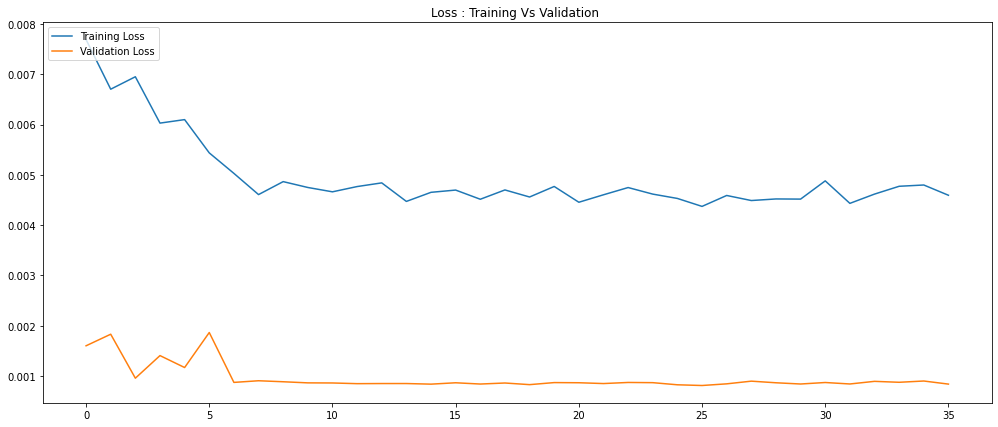

In [22]:
loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(17, 7));
plt.plot(loss, label='Training Loss');
plt.plot(validation_loss, label='Validation Loss');
plt.legend(loc='upper left');
plt.title('Loss : Training Vs Validation ');

# Prediction

In [23]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [24]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

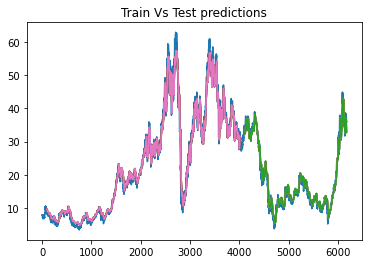

In [34]:
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) + 1: len(df) - 1, :] = test_predict

plt.plot(df["Close"])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Train Vs Test predictions');
plt.show()

# Evaluation

In [59]:
from sklearn.metrics import mean_squared_error
print("Train RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test RMSE: ", math.sqrt(mean_squared_error(ytest,test_predict)))

Train RMSE:  27.820727955477253
Test RMSE:  20.553427564813937
